# Importing necessary libraries

In [ ]:
import os
import random
import multiprocessing
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from matplotlib import style
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
style.use('fivethirtyeight')

# Setting up Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Traffic sign recognition/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Traffic sign recognition
dataset  model	Model.ipynb  requirements.txt


# Directory paths


In [ ]:
data_dir = "/content/drive/MyDrive/Traffic sign recognition/dataset"
train_path = os.path.join(data_dir, 'Train')
test_path = os.path.join(data_dir, 'Test')

# Constants for image resizing

In [ ]:
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

# Number of categories


In [ ]:
no_categories = len(os.listdir(train_path))
print(f"Available Numbers of Categories in dataset : {no_categories}")

Available Numbers of Categories in dataset : 43


# Mapping classes to their labels

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

# Visualizing Class Distribution


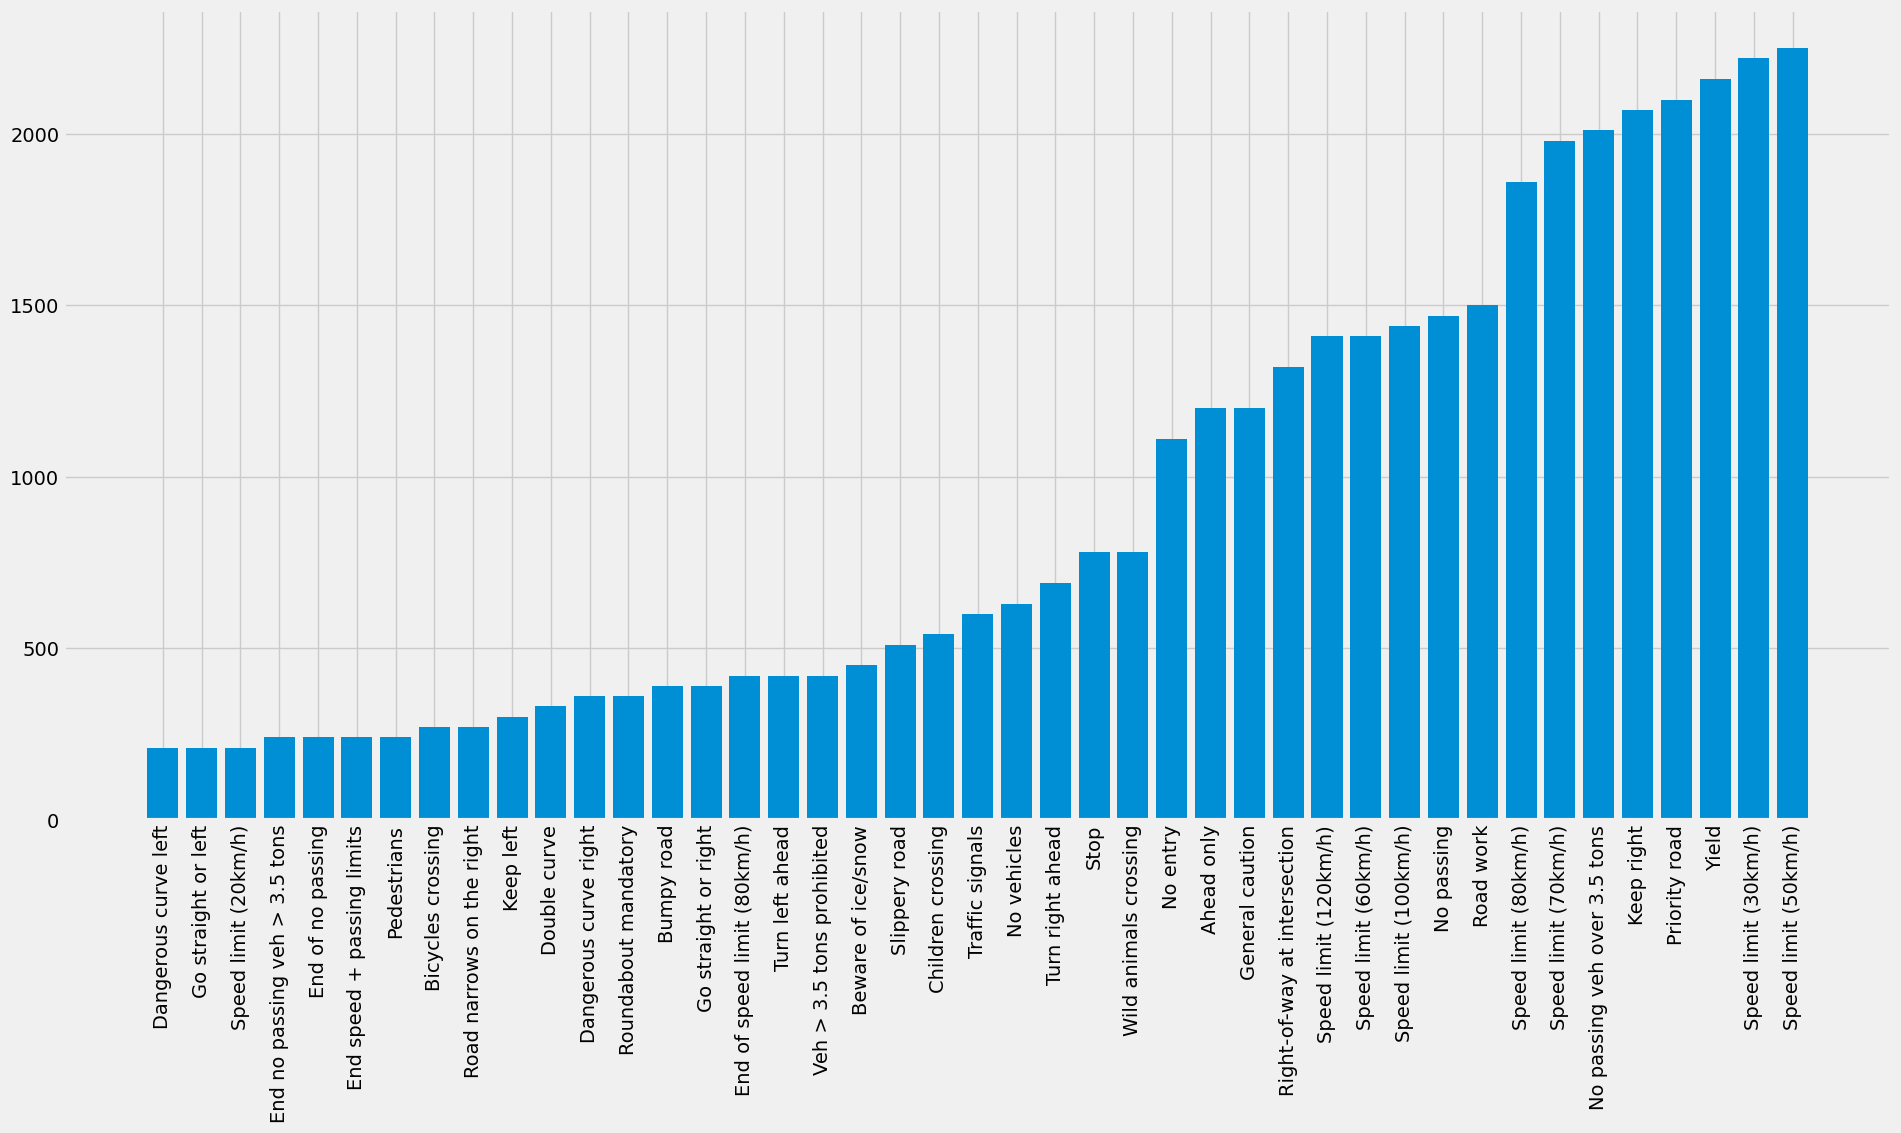

In [ ]:
# Listing folders in the training directory
folders = os.listdir(train_path)

# Lists to store number of images and class names
train_number = []
class_num = []

# Counting the number of images in each class
for folder in folders:
    train_files = os.listdir(os.path.join(train_path, folder))
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset based on the number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# Visualizing 25 random images along with their dimensions from test data

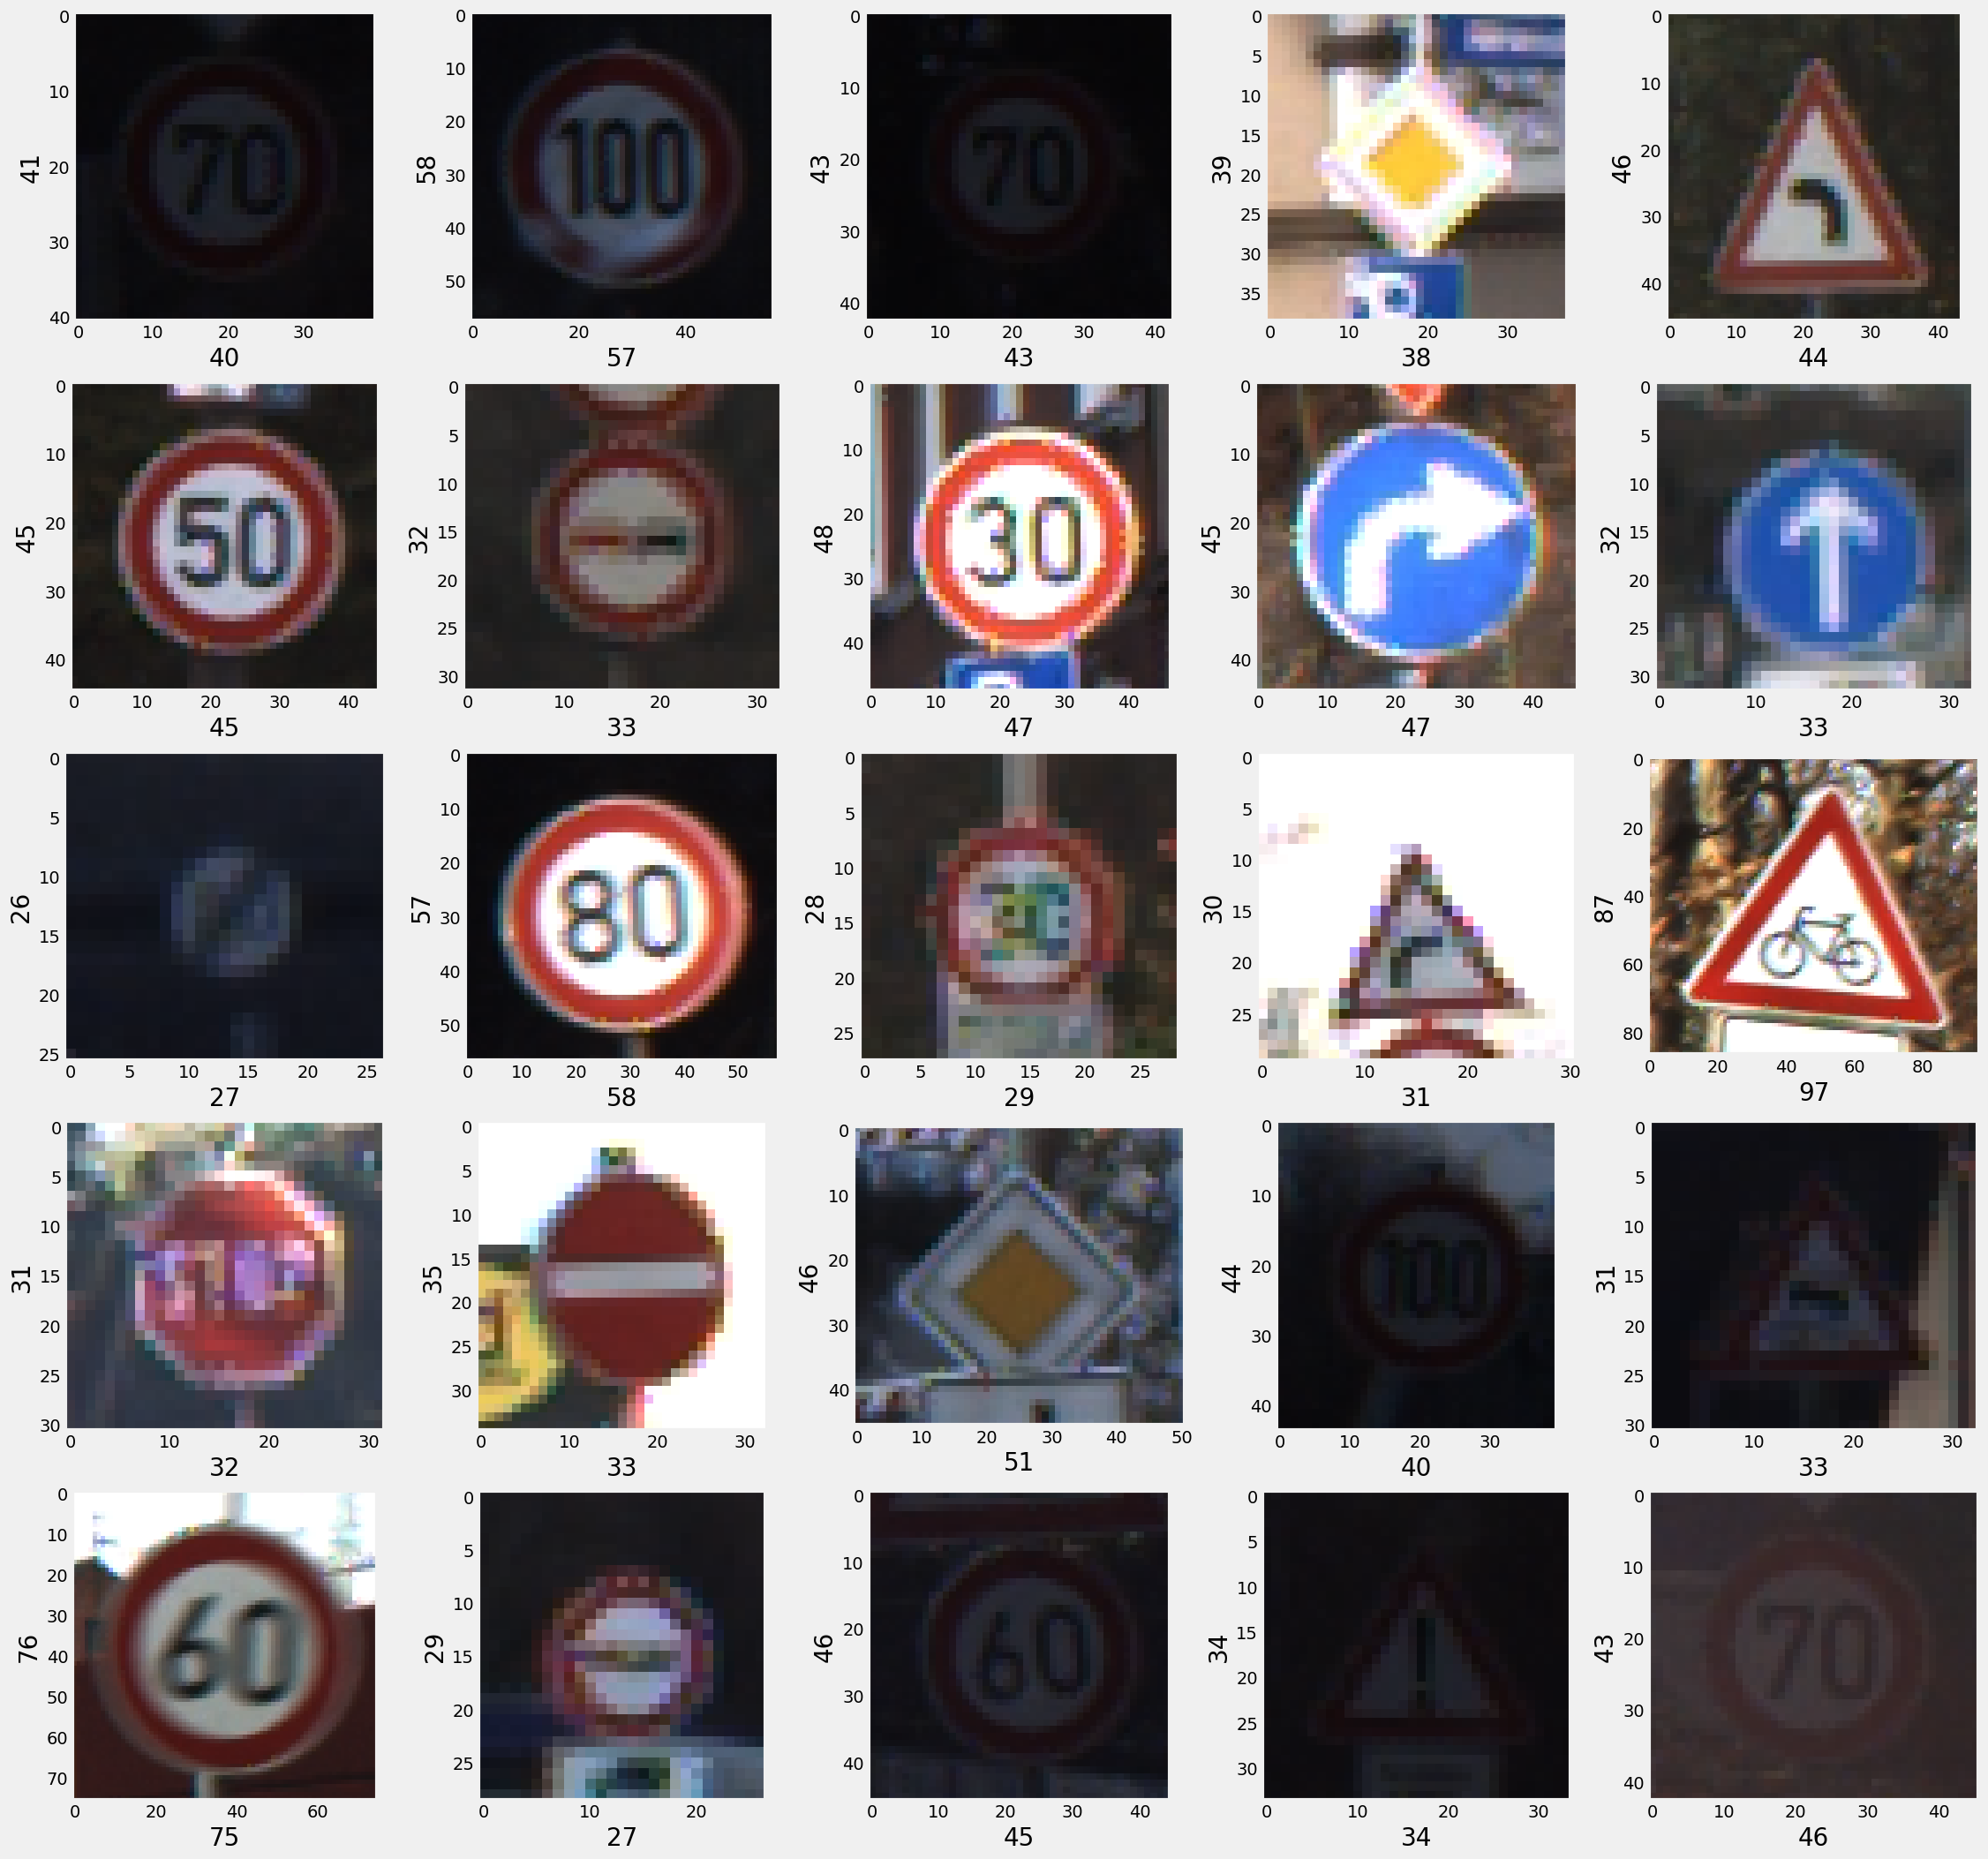

In [ ]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(20,20))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)  # Turn off grid
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data by resizing it to the specified dimensions.

In [ ]:
#Process a single image by resizing it to the specified dimensions.
def process_image(image_path, category_index, IMG_HEIGHT, IMG_WIDTH):
    try:
        image = cv2.imread(image_path)
        pil_image = Image.fromarray(image, 'RGB')
        resized_image = pil_image.resize((IMG_HEIGHT, IMG_WIDTH))
        return np.array(resized_image), category_index #Resized image data.
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def load_images_parallel(data_dir, IMG_HEIGHT, IMG_WIDTH):
    image_data = []
    image_labels = []
    pool = multiprocessing.Pool()
    for category_index in range(no_categories):
        category_path = os.path.join(data_dir, 'Train', str(category_index))
        image_files = os.listdir(category_path)
        # Map the process_image function to each image in the category
        category_data = pool.starmap(process_image, [(os.path.join(category_path, image_file), category_index, IMG_HEIGHT, IMG_WIDTH) for image_file in image_files])

        # Filter out None values (errors during processing)
        category_data = [data for data in category_data if data is not None]

        # Unpack and append the processed data
        image_data.extend([data[0] for data in category_data])
        image_labels.extend([data[1] for data in category_data])

    # Close the pool of worker processes
    pool.close()
    pool.join()
    return np.array(image_data), np.array(image_labels)

# Usage example:
image_data, image_labels = load_images_parallel(data_dir, IMG_HEIGHT, IMG_WIDTH)
print("Image data shape:", image_data.shape)
print("Image labels shape:", image_labels.shape)

Image data shape: (39209, 30, 30, 3)
Image labels shape: (39209,)


# Shuffling the training data

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# Splitting the data into train and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# Dividing by 255 is a simple way to normalize pixel values in the range [0, 1]
X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


# One hot encoding the labels

In [ ]:
y_train = keras.utils.to_categorical(y_train, no_categories)
y_val = keras.utils.to_categorical(y_val, no_categories)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# Define model architecture

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

# Compile the model

In [ ]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Data Augmentation


In [ ]:
image_augmentor = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

# Train the model

In [ ]:
history = model.fit(
    image_augmentor.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
858/858 [==============================] - 154s 180ms/step - loss: 0.0548 - accuracy: 0.9832 - val_loss: 0.0080 - val_accuracy: 0.9976
Epoch 2/30
858/858 [==============================] - 104s 121ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.0162 - val_accuracy: 0.9952
Epoch 3/30
858/858 [==============================] - 109s 127ms/step - loss: 0.0500 - accuracy: 0.9851 - val_loss: 0.0152 - val_accuracy: 0.9953
Epoch 4/30
858/858 [==============================] - 102s 119ms/step - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.0069 - val_accuracy: 0.9979
Epoch 5/30
858/858 [==============================] - 105s 122ms/step - loss: 0.0382 - accuracy: 0.9886 - val_loss: 0.0105 - val_accuracy: 0.9969
Epoch 6/30
858/858 [==============================] - 99s 116ms/step - loss: 0.0435 - accuracy: 0.9869 - val_loss: 0.0311 - val_accuracy: 0.9926
Epoch 7/30
858/858 [==============================] - 98s 114ms/step - loss: 0.0364 - accuracy: 0.9891 - val_loss: 0.0079 - v

# Save model and its weights, then load them

In [ ]:
# Save the entire model
model.save("/content/drive/MyDrive/Traffic sign recognition/model/model.h5")

# Save only the weights of the original model to files
model.save_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the entire model
loaded_model = keras.models.load_model("/content/drive/MyDrive/Traffic sign recognition/model/model.h5")

# Load only the weights into the model
loaded_model.load_weights("/content/drive/MyDrive/Traffic sign recognition/model/model_weights")

In [ ]:
loaded_model

## Evaluating the model

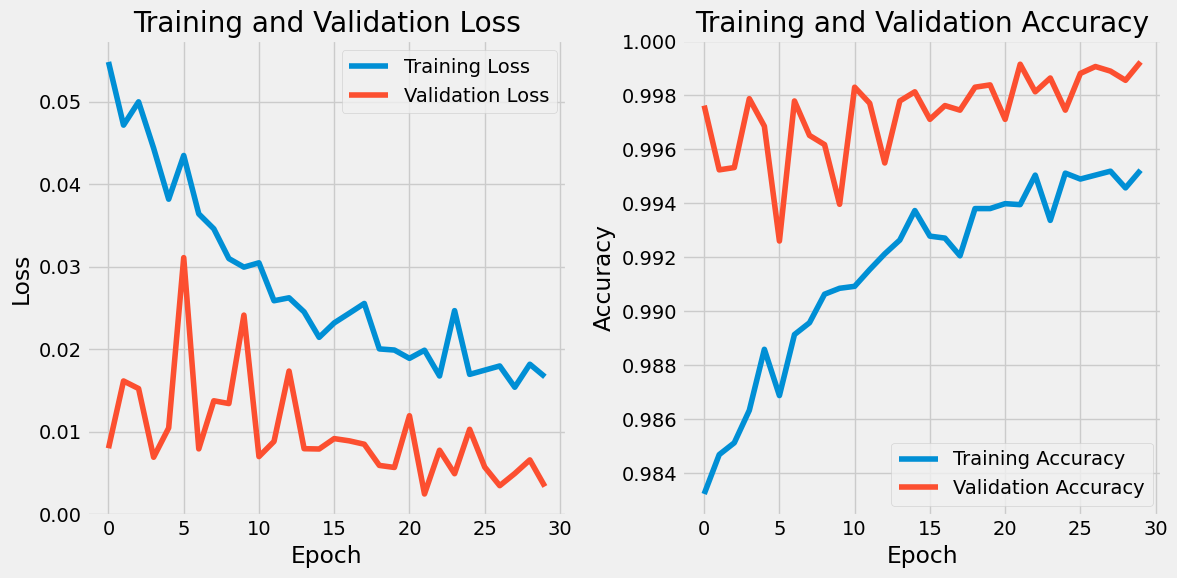

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Loading the test data and running the predictions

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
# Resizing the images
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255

# Get class probabilities for each image
pred_probs = loaded_model.predict(X_test)

# Convert probabilities to class labels
pred_classes = np.argmax(pred_probs, axis=1)


# Calculate accuracy
accuracy = accuracy_score(labels, pred_classes)
print(f"The accuracy on test data: {accuracy * 100:.2f}%")

395/395 [==============================] - 10s 25ms/step


## Visualizing the Confusion Matrix

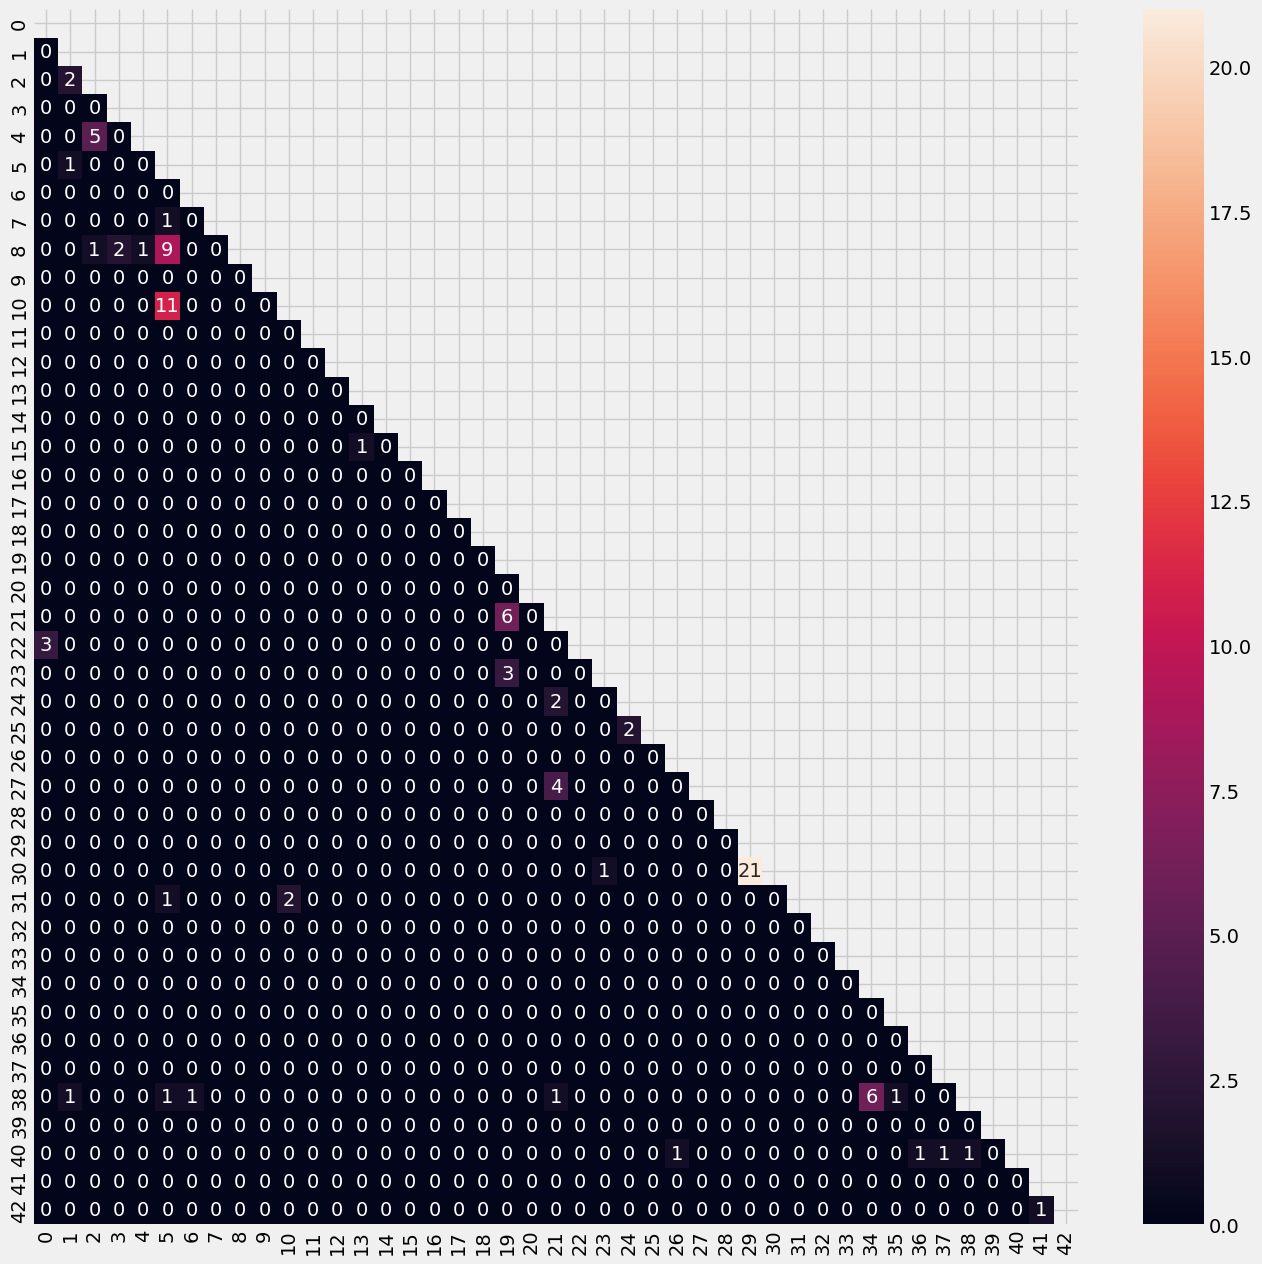

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, pred_classes)

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(conf_matrix, dtype=bool))

# Create DataFrame for the confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the heatmap with the upper triangle only
plt.figure(figsize=(15, 15))
sns.heatmap(df_cm, annot=True, mask=mask)
plt.show()

## Classification report

In [ ]:
report = classification_report(labels, pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       1.00      0.96      0.98       450
           4       1.00      0.99      0.99       660
           5       0.94      1.00      0.97       630
           6       0.99      0.97      0.98       150
           7       1.00      1.00      1.00       450
           8       1.00      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.98      0.99       660
          11       1.00      0.95      0.97       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.96      1.00      0.98       210
          16       0.99      1.00      1.00       150
          17       1.00    

## Visualize Predictions on Test Data

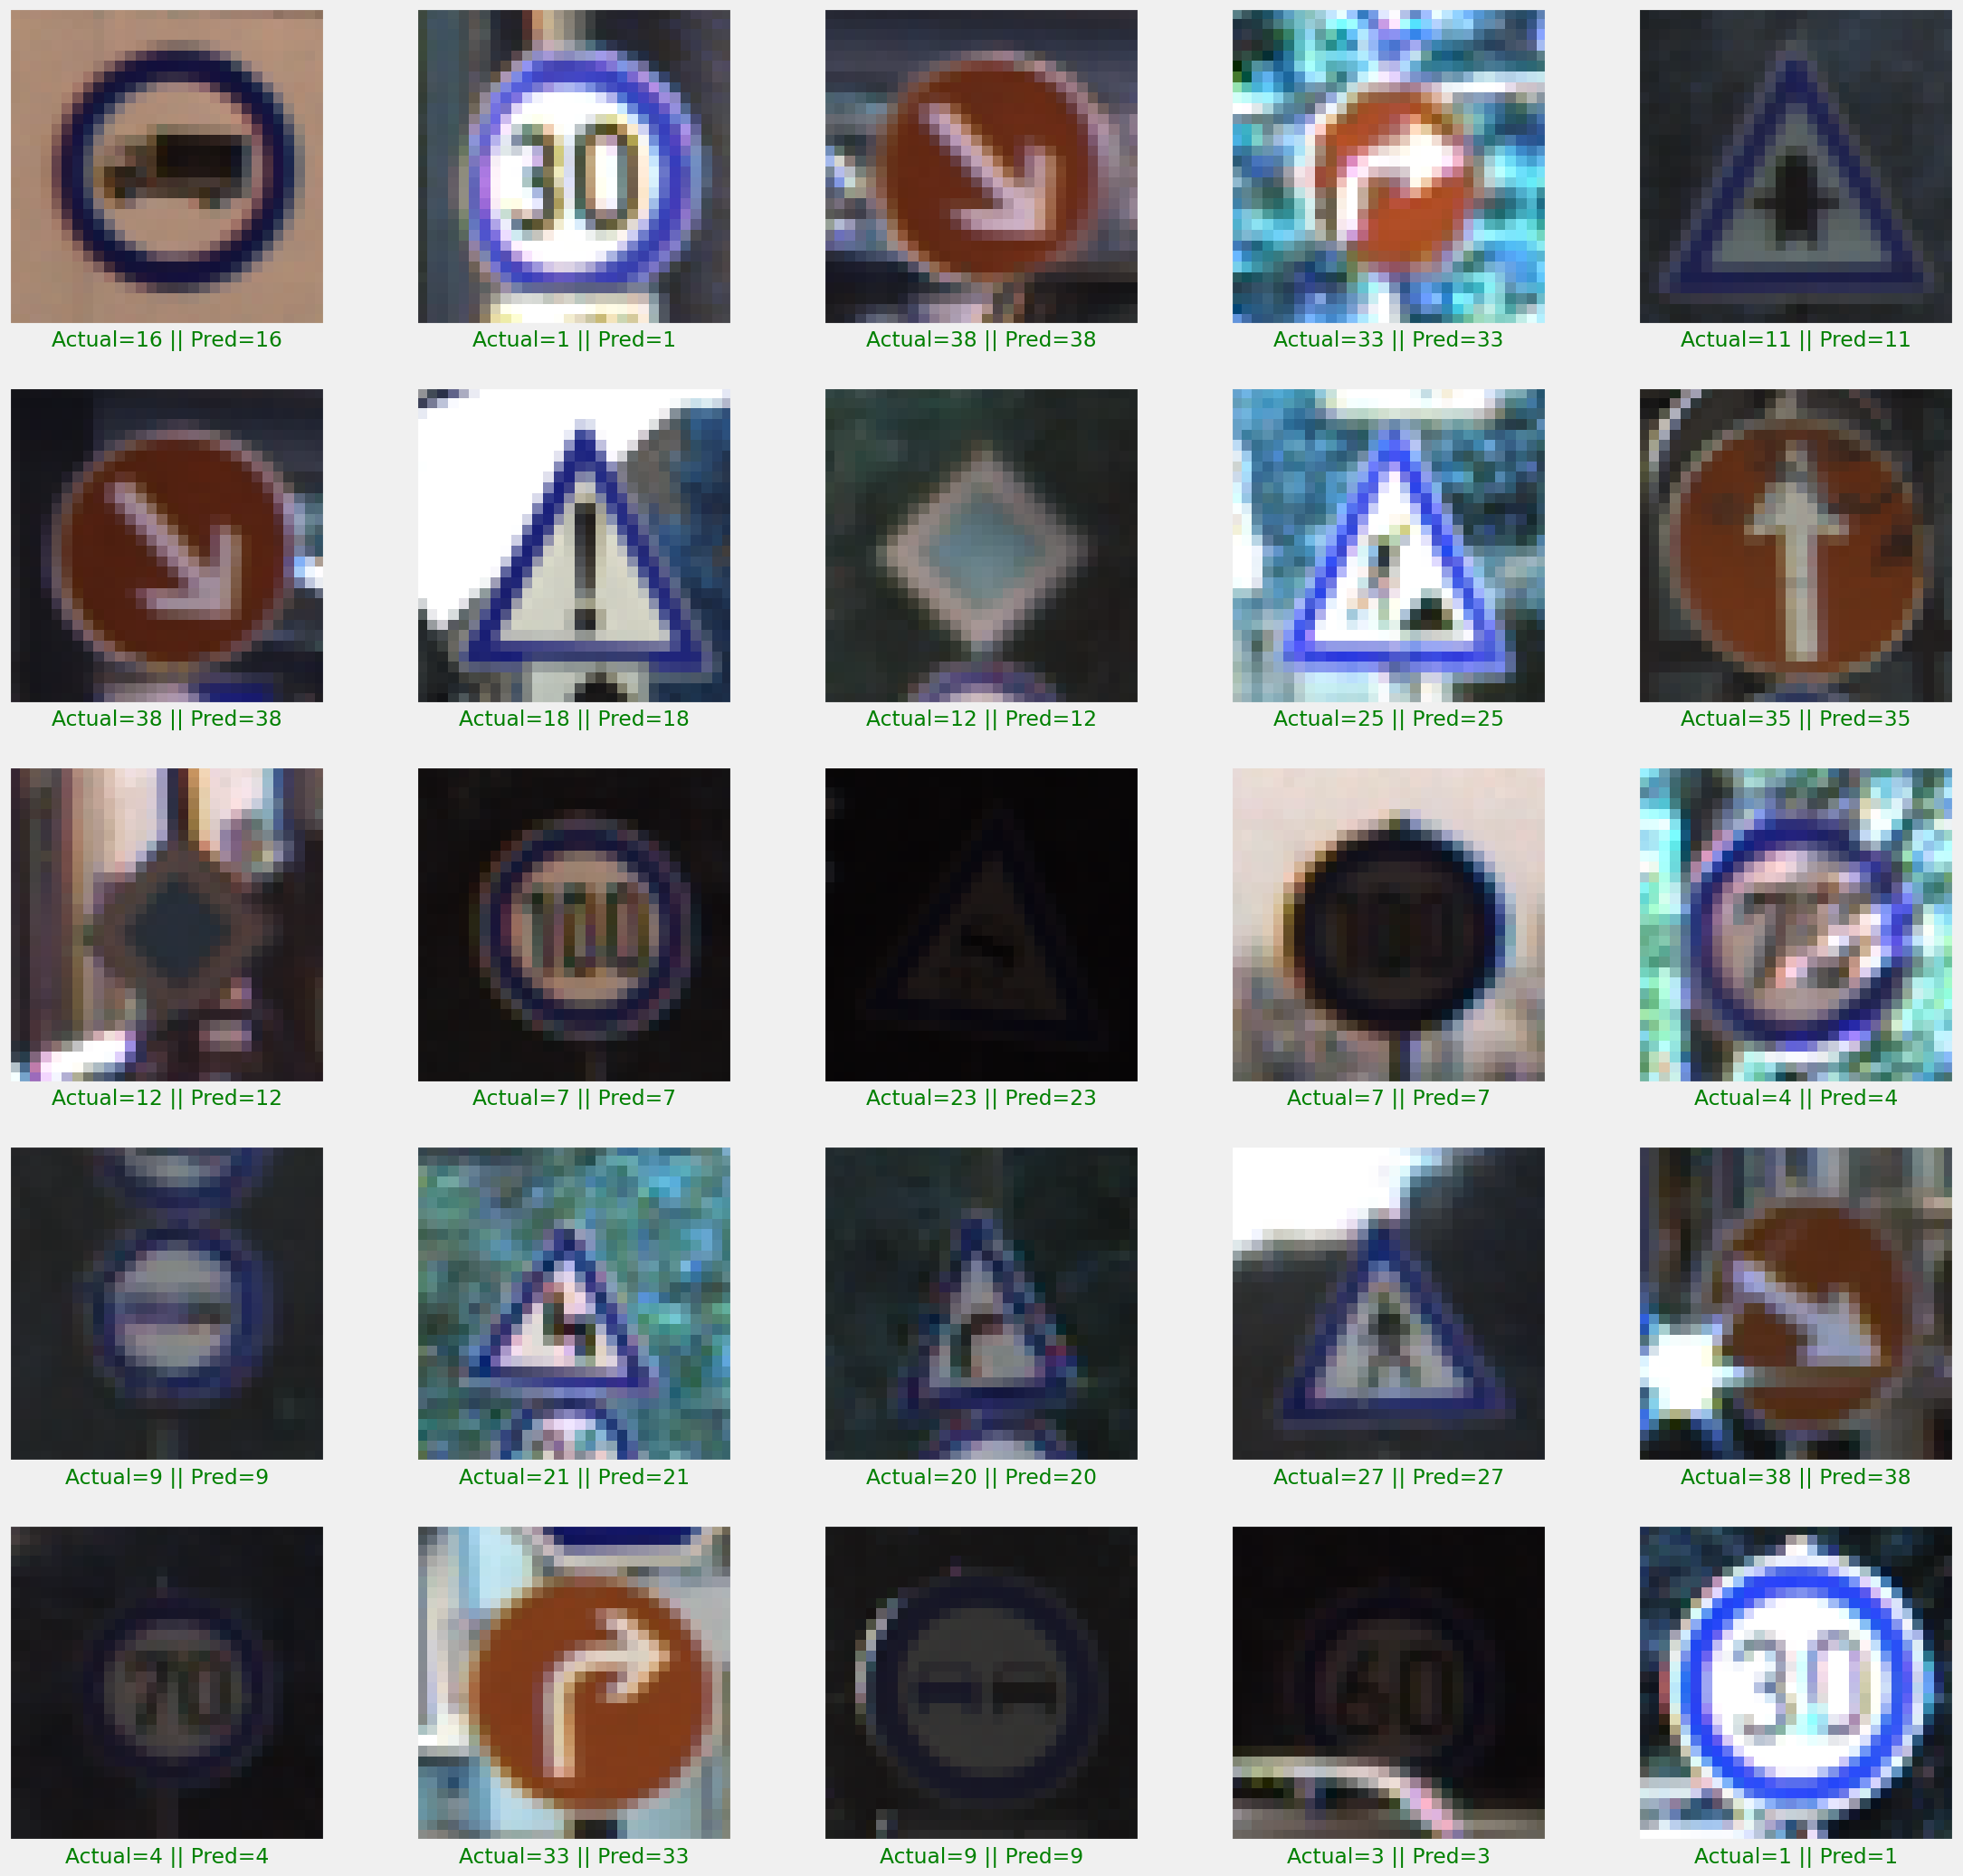

In [ ]:
def plot_predictions(images, true_labels, predicted_labels, start_index=0, num_images=25):
    plt.figure(figsize=(25, 25))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = predicted_labels[start_index + i]
        actual = true_labels[start_index + i]
        col = 'g' if prediction == actual else 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color=col)
        plt.imshow(images[start_index + i])
    plt.show()

# Display predictions for test data
plot_predictions(X_test, labels, pred_classes)

1/1 [==============================] - 0s 35ms/step


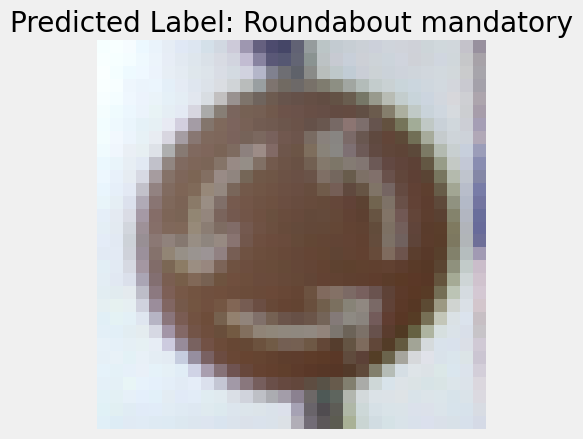

In [ ]:
# Read the image
image = cv2.imread("/content/drive/MyDrive/Traffic sign recognition/test_image.png")

# Resize and preprocess the image
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data / 255

# Make prediction
pred = loaded_model.predict(input_data)
result = pred.argmax()
predicted_label = classes[result]

# Display the image
plt.imshow(resize_image)
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}')
plt.show()